## Chapter 12
#### Brian Reppeto 530 Prof. Jim Week 10 HW

12-1

In [19]:
# import libraries

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import random
import thinkstats2
import thinkplot

In [20]:
# read the mj-clean file

transactions = pd.read_csv("mj-clean.csv", parse_dates=[5])

In [21]:
# head the new df

transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [24]:
# create a function to process transactions aggregated by date and summarize the data for each day

def GroupByDay(transactions, func=np.mean):
    grouped = transactions[["date", "ppg"]].groupby("date")
    daily = grouped.aggregate(func)
    daily["date"] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, "Y")
    daily["years"] = (daily.date - start) / one_year

    return daily

In [25]:
# create a function to group transaction data by both quality and date

def GroupByQualityAndDay(transactions):
    groups = transactions.groupby("quality")
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)

    return dailies

In [26]:
# call the groupbyquality function with transactions as the argument to process transactions

dailies = GroupByQualityAndDay(transactions)

In [27]:
# create a function to fit a quadratic regression model to a dataset

def RunQuadraticModel(daily):
    daily["years2"] = daily.years**2
    model = smf.ols("ppg ~ years + years2", data=daily)
    results = model.fit()
    return model, results

In [28]:
# apply the runquadraticmodel function to a subset of daily data filtered to high

name = "high"
daily = dailies[name]

model, results = RunQuadraticModel(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          4.57e-164
Time:                        16:08:22   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1164      0.084    -13.326      0.000      -1.281      -0.952
years2         0.1131      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# create a function to plot the original data points and the fitted values from a regression model

def PlotFittedValues(model, results, label=""):
    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label="model", color="#ff7f00")

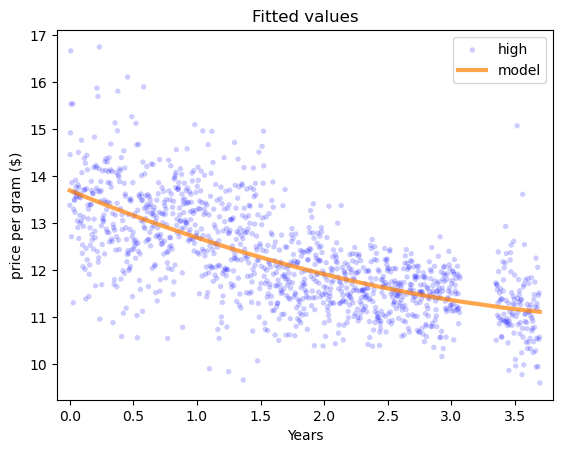

In [30]:
# plot the fitted values from a regression model against the actual data points

PlotFittedValues(model, results, label=name)
thinkplot.Config(title="Fitted values", 
                 xlabel="Years", xlim=[-0.1, 3.8], 
                 ylabel="price per gram ($)")

In [34]:
# create a function to fit a linear regression model to predict a dependent variable  

def RunLinearModel(daily):
    model = smf.ols("ppg ~ years", data=daily)
    results = model.fit()
    return model, results

In [35]:
# create a function to visualize the predictions of a statistical model 
# with confidence intervals, for a given dataset over a specified range of years

def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color="gray")

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color="gray")

In [37]:
# create a function to perform simulations on a dataset to assess the variability of model predictions
# using a specified model function linear regression

def SimulateResults(daily, iters=101, func=RunLinearModel):
    _, results = func(daily)
    fake = daily.copy()

    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

In [39]:
# create a function to generate predictions from a sequence of model results for specified years

def GeneratePredictions(result_seq, years, add_resid=False):
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)

    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

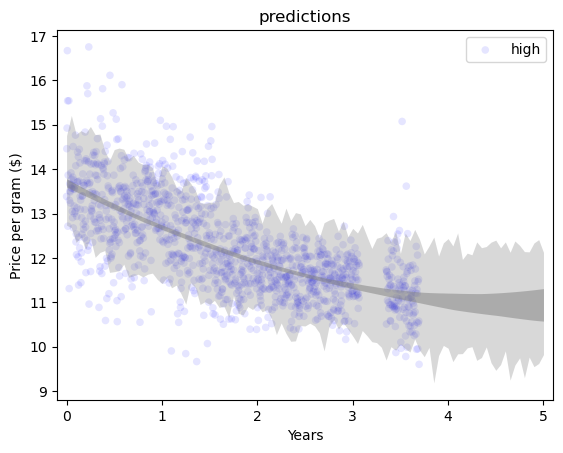

In [40]:
# plot observed data points and predict future values based on a quadratic model

years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(
    title="predictions",
    xlabel="Years",
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)",)

12-2

In [41]:
# create a class designed to test for serial correlation in a dataset


class SerialCorrelationTest(thinkstats2.HypothesisTest):
   
    def TestStatistic(self, data):  # this method calculates the test statistic for the absolute value of the serial correlation 
        series, lag = data          # for a given series of data and a specified lag
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):          # this method simulates the null hypothesis which involves randomly shuffling the 
        series, lag = self.data  # series' values while keeping the lag constant
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [43]:
# create a function to calculate the autocorrelation of a given series with a specified lag

def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [44]:
# test for serial correlation in a daily time series data set looking for correlation of data points

name = "high"
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.48522937619473755 0.0


In [45]:
# chech the presence of serial correlation in the residuals of a linear regression model

_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.07570473767506251 0.007


In [46]:
# evaluate the presence of serial correlation in the residuals of a quadratic model fitted to a dataset

_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.05607308161289923 0.05
